# Agent1 - Planner Agent

## State
Trip Preferences
- duration
- themes
- intensity
- companions
- transport
- is_complete
- missing_info_question

## Agent State
- Messages
- Preferences

In [ ]:
import operator
from typing import TypedDict, Annotated, List, Optional, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import json
from langgraph.checkpoint.memory import MemorySaver

# Agent가 채워 넣어야 할 데이터 구조 정의
# --- 1. Agent 1 데이터 스키마 (TripPreferences) ---
class TripPreferences(BaseModel):
    # 1. 기간
    duration: int = Field(
        None,
        description="여행 기간. 예: '1', '2', '3' 등 체류할 기간을 숫자로 명시한다. 1박 2일이면 2일을 체류하기 때문에 2를 저장한다. 몇 박 묵을지는 궁금하지 않다. 명시되지 않으면 None."
    )

    # 2. 여행 지역 (여기에 추가!)
    target_area: Optional[str] = Field(
        default=None,
        description="구체적인 서울의 여행 지역. 예: '종로구', '성수동', '강남', '홍대', '잠실'. 명시되지 않으면 None."
    )

    # 3. 테마 (여러 개일 수 있으니 List로)
    themes: List[Literal['맛집', '쇼핑', '문화/예술', '힐링', '체험/액티비티', '뷰/야경', '트렌드']] = Field(
        default_factory=list,
        description="여행 테마 리스트. 사용자의 입력에서 유추할 수 있는 **모든** 테마를 전부 선택하세요. 하나만 선택하지 말고, 해당되는 것은 다 포함시키세요."
    )

    # 4. 강도 (숫자로 변환)
    intensity: int = Field(
        None,
        description="여행 강도 (0~100). 0은 완전한 휴식, 100은 빡빡한 일정. 강도를 단순히 0, 50, 100으로 나누지 말고, 사용자의 입력에 대해서 적절한 값으로 반환합니다. 정보가 없으면 None"
    )
    
    # 5. 동행자
    companions: Optional[Literal['혼자', '친구', '연인', '가족(아이)', '가족(부모님)']] = Field(
        None,
        description="동행자 유형. 예: '혼자', '친구', '연인', '가족(아이)', '가족(부모님)'. 정보가 없으면 None"
    )
    
    # 6. 이동 방식
    transport: Optional[Literal['대중교통', '도보', '차량']] = Field(
        None,
        description="이동 수단 선호. 사용자의 입력에서 유추할 수 있는 **모든** 테마를 전부 선택하세요. 하나만 선택하지 말고, 해당되는 것은 다 포함시키세요. 정보가 없다면 None"
    )

    # 7. HITL 필수 필드 (대화 제어용)
    is_complete: bool = Field(
        False,
        description="위 6가지 필수 정보(duration, themes, intensity, companions, transport, target_area)가 모두 채워졌는지 여부."
    )
    
    # 8. 부족한 부분을 채우기 위한 질문지
    missing_info_question: Optional[str] = Field(
        None, 
        description="정보가 부족할 경우 사용자에게 던질 질문. (부족한 항목을 콕 집어서 질문)"
    )

    # 9. 기타 (혹시 모를 추가 요청사항)
    additional_notes: Optional[str] = Field(
        None,
        description="""
        사용자의 여행 계획을 요약한 '종합 브리핑'입니다. 다음 두 가지 내용을 자연스러운 줄글로 통합하여 작성하세요.
        1. [요약]: 추출된 5가지 필수 정보(누구와, 기간, 테마, 강도, 이동수단)를 포함하여 여행의 전체 그림을 서술.
        2. [맥락]: 위 5가지 카테고리에 딱 들어맞지 않는 구체적인 요구사항이나 제약조건(예: '다리가 아파요', '매운 음식 못 먹어요', '특정 유튜버 맛집')도 빠짐없이 포함.
        ※ 정보가 부족하다면, 현재까지 파악된 내용만으로 요약합니다.
        """
    )


class AgentState(TypedDict):
    # 입력: 사용자의 질문
    messages: Annotated[List[BaseMessage], operator.add]

    # 출력: Agent 1이 채워넣을 분석 결과 (초기에는 None일 수 있음)
    preferences: TripPreferences
    
    
def planner_node(state: AgentState):
   print("🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---")
   
   # 2. LLM 설정 (구조화된 출력)
   llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)
   structured_llm = llm.with_structured_output(TripPreferences)

   # 현재 상태 가져오기
   current_pref = state.get("preferences", TripPreferences())

   # 시스템 프롬프트: "5가지가 다 모여야 탈출 가능"
   system_prompt = f"""
   당신은 한국어, 영어, 일본어, 중국어에 모두 능통한 '베테랑 여행 플래너'입니다.
   사용자의 입력과 대화 내역을 분석하여 여행 정보를 추출하세요.
   
   [현재 파악된 정보]
   {json.dumps(current_pref.model_dump(), indent=2, ensure_ascii=False)}
   
   [필수 확보 정보 (5-Check)]
   여행 계획을 짜기 위해 다음 5가지 정보는 **반드시** 값이 있어야 합니다.
   1. duration (기간)
   2. target_area (여행 지역 - 예: 종로, 성수, 강남 등)
   3. themes (테마 - 최소 1개 이상)
   4. intensity (여행 강도)
   5. companions (동행자)
   6. transport (이동 수단)

   [언어 처리 규칙 (매우 중요)]
   1. **언어 감지**: 사용자가 입력한 언어(한/영/일/중)를 감지하세요.
   2. **데이터 매핑 (Internal)**: 사용자가 외국어로 말하더라도, 추출하는 값은 반드시 스키마에 정의된 **'한국어 표준 값'**으로 변환하여 저장하세요.
      - 예: User "I want to go shopping" -> themes=['쇼핑'] (NOT 'Shopping')
      - 예: User "電車で行きます (전철로 갈래요)" -> transport='대중교통'
   3. **질문 생성 (External)**: `missing_info_question`은 반드시 **사용자가 입력한 언어**로 작성하세요.
      - 예: 사용자가 일본어로 말했으면, 질문도 일본어로 생성.
   
   [지시사항]
   - 위 6가지 중 하나라도 값이 없거나(None), 빈 리스트라면 'is_complete'는 False입니다.
   - 'is_complete'가 False라면, 부족한 정보가 무엇인지 파악하여 사용자에게 자연스럽게 물어보는 질문을 'missing_info_question'에 작성하세요.
   - **특히 '지역(target_area)'이 없다면, "서울의 어느 동네를 보고 싶으신가요? (예: 종로, 성수, 강남)" 하고 물어보세요.**
   - 만약 사용자가 "잘 모르겠어요"라고 하면, 테마를 보고 추천해주지 말고 "추천해드릴까요?"라고 되물어서 지역을 확정 짓도록 유도하세요.
   - **질문은 친절하고 정중한 톤을 유지하세요.**
   - 모든 정보가 채워졌을 때만 'is_complete'를 True로 설정하세요.
   """

   messages = [SystemMessage(content=system_prompt)] + state["messages"]
   
   result = structured_llm.invoke(messages)
   
   return {"preferences": result}

from langgraph.graph import StateGraph, END, START

# 1) 그래프 초기화 (어떤 State를 사용할 건지 결정)
workflow = StateGraph(AgentState)

# 2) 노드 등록
# "planner"라는 이름표를 붙여서 planner_node 함수를 등록
workflow.add_node("planner", planner_node)

# 3) 엣지 연결 (순서 정의)
# workflow.add_edge(START, "process")
workflow.set_entry_point("planner")
workflow.add_edge("planner", END)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

import time
# if __name__ == "__main__":
#     print("🤖 Agent: 서울 여행 계획을 도와드릴게요! (종료: q)")

#     # config 설정 (이게 있어야 기억이 유지됨)
#     config = {"configurable": {"thread_id": "1"}}

#     current_prefs = TripPreferences()
#     chat_history = []
    
#     while True:
#         user_input = input("\n👤 유저: ")
#         if user_input.lower() == 'q': break
        
#         # 상태 주입
#         inputs = {
#             "messages": [HumanMessage(content=user_input)],
#             "preferences": current_prefs
#         }
        
#         # 실행
#         result_state = app.invoke(inputs, config=config)
#         print(result_state)
#         current_prefs = result_state['preferences']
        
#         # 검증 로직
#         if current_prefs.is_complete:
#             print(f"\n✅ [모든 정보 확보 완료]")
#             print(f"기간: {current_prefs.duration}")
#             print(f"동행: {current_prefs.companions}")
#             print(f"테마: {current_prefs.themes}")
#             print(f"강도: {current_prefs.intensity}")
#             print(f"이동: {current_prefs.transport}")
#             print(f"기타: {current_prefs.additional_notes}")
#             break
#         else:
#             # 질문 출력
#             print(f"🤖 Agent: {current_prefs.missing_info_question}")
#             time.sleep(1)
#             # (디버깅용: 현재 채워진 정보 확인)
#             print(f"(Debug) 현재 상태: {current_prefs.model_dump(exclude={'missing_info_question', 'is_complete'})}")

# Agent2

# State

In [2]:
# Kakao Local API 코드 기반 할당
class CategoryAllocation(BaseModel):
    category_group_code: Literal[
        'FD6', 'CE7', 'CT1', 'AT4', 'AD5', # 핵심 (식음료, 관광, 숙박)
        'PK6', 'OL7', 'SW8',               # 교통 (주차, 주유, 지하철)
        'MT1', 'CS2'                       # 편의 (마트, 편의점)
        # HP8(병원), PM9(약국) 등은 특수 상황 아니면 제외 (필요시 추가 가능)
    ] = Field(
            description = "Kakao Map API의 카테고리 그룹 코드(MT1:대형마트, CS2:편의점, PS3:어린이집, 유치원, SC4:학교, AC5:학원, PK6:주차장, OL7:주유소, 충전소, SW8:지하철역, BK9:은행, CT1:문화시설, AG2:중개업소, PO3:공공기관, AT4:관광명소, AD5:숙박, FD6:음식점, CE7:카페, HP8:병원, PM9:약국)"
    )
    
    keywords: List[str] = Field(
        description="인터넷 검색할 때 필요한 구체적인 키워드 리스트. Agent 1이 정한 지역명을 포함해서 작성한다."
    )

    count: int = Field(description="필요한 장소의 개수 (여행 기간에 비례)")

    weight: int = Field(description="검색 우선순위 가중치 (1~10). 점수가 높을수록 '여행의 메인 목적'이며, 먼저 검색되어 기준점(Anchor)이 됩니다.")
    reason: str = Field(
        description="해당 category_group_code들을 선택한 이유"
    )

class ItineraryStrategy(BaseModel):
    allocations: List[CategoryAllocation] = Field(
        description="카테고리 코드별 할당 리스트"
    )

class AgentState(TypedDict):
    # 1. 대화 기록 (공통)
    messages: Annotated[List[BaseMessage], operator.add]

    # 2. Agent 1의 결과물 (User Preferences)
    preferences: Optional[TripPreferences]

    # 3. Agent 2의 결과물 (Search Strategy)
    strategy: Optional[ItineraryStrategy]


# Node

In [3]:
def allocator_node(state: AgentState):
   print("\n⚖️ --- [Agent 2] Kakao 코드 기반 할당 전략 수립 중 ---")

   # Agent 1의 결과 (TripPreferences)
   preferences = state['preferences']
   target_area = preferences.target_area
   duration = preferences.duration
   # 수정사항
   # 지금은 모든 node에서 llm을 ? 하고 있는데, 이걸 global로 변경할 필요는 있다.
   
   llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)
   structured_llm = llm.with_structured_output(ItineraryStrategy)

   system_prompt = f"""
   당신은 치밀한 여행 전략가입니다. 
   Agent 1이 분석한 **여행 지역({target_area})**과 사용자 선호도를 바탕으로, 우선순위(weight)와 수량(count)이 포함된 Kakao Map API 카테고리 코드를 활용한 검색 전략을 수립하세요.
   
   [사용자 선호도]
   {json.dumps(preferences.model_dump(), indent=2, ensure_ascii=False)}
   
   [중요: 검색 타겟 지역]
    **{target_area}**
    
    [전략 수립 로직 (Algorithm)]
    
    1. **수량(Count) 산정**: 여행 기간({duration})에 비례하여 결정하세요.
       - 당일치기: 총 3~5곳 (식당1, 카페1, 관광1 등)
       - 1박 2일: 총 6~8곳 (식당3, 카페2, 관광2, 숙소1 등)
       - 2박 3일: 총 9~12곳
       
    2. **가중치(Weight) 부여 (핵심)**:
       - **Anchor (Weight 8~10)**: 여행 테마(themes)와 가장 밀접한 카테고리.
         (예: '맛집 투어' -> FD6=10, '힐링' -> CE7=10, '관광' -> AT4=10)
         (예: 숙박 여행인 경우 AD5(숙소)는 동선의 기준이 되므로 Weight 9 이상 부여)
       - **Satellite (Weight 1~5)**: 메인 장소 근처에서 가볍게 들를 곳.
         (예: 맛집 갔다가 갈 카페, 관광지 근처 편의점/주차장)

   [Kakao Category Code 매핑 규칙 (여행 관점)]
   
   1. **핵심 여행지 (Main Spots)**
      - **FD6 (음식점)**: '맛집' 테마 필수. 모든 여행의 기본 식사 장소.
      - **CE7 (카페)**: '힐링', '트렌드', '카페' 테마 필수. 휴식이 필요할 때 할당.
      - **AT4 (관광명소)**: '관광', '야경', '체험', '뷰' 테마일 때 할당. (가장 우선순위 높음)
      - **CT1 (문화시설)**: '문화/예술' 테마일 때 할당 (박물관, 미술관, 공연장).
      - **AD5 (숙박)**: 기간({duration})이 당일치기가 아닌 경우(1박 이상) 필수 할당.
      
   2. **쇼핑 및 편의 (Shopping & Convenience)**
      - **MT1 (대형마트)**: '쇼핑' 테마 중에서도 식료품/기념품 구매 혹은 펜션 여행 장보기 필요 시.
      - **CS2 (편의점)**: 구체적인 할당보다는, 숙소 근처나 한강 공원 등에서 '간식' 키워드가 있을 때 보조적으로 사용.
      
   3. **교통 및 이동 (Transport)**
      - **PK6 (주차장)**: 이동수단이 **'차량'**일 때, 주요 관광지(AT4)나 식당(FD6) 근처 주차장 검색용으로 추가 할당.
      - **OL7 (주유소/충전소)**: 이동수단이 **'차량'**이고 장거리 이동 시 고려.
      - **SW8 (지하철역)**: 이동수단이 **'대중교통'**일 때, 여행의 시작점이나 만남의 장소(Anchor)로 활용.
   
   [할당 전략 (Logic)]
   1. **테마 매칭**: 사용자의 `themes` 리스트를 보고 위 코드를 조합하세요. (예: '힐링+맛집' -> CE7 + FD6 집중)
   2. **강도 조절**:
      - 강도 높음(>70): AT4(관광), CT1(문화) 개수 증가 (많이 걷고 구경).
      - 강도 낮음(<30): CE7(카페), FD6(식당) 위주로 동선 최소화.
   3. **키워드 생성**:
      - `keywords` 작성 시 단순 '맛집'이 아니라 `additional_notes`의 맥락을 반영해 구체적으로 적으세요.
      - 예: "종로 주차 가능한 맛집" (FD6 + PK6 고려)
   """
   message = [SystemMessage(content=system_prompt)]

   result = structured_llm.invoke(message)
   print(result)
   return {"strategy": result}
    

# WorkFlow

In [4]:
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("allocator", allocator_node)

# 순서 연결
workflow.set_entry_point("planner")

def check_complete(state: AgentState):
    if state['preferences'].is_complete:
        return "allocator"
    return END

workflow.add_conditional_edges(
    "planner",
    check_complete,
    {"allocator": "allocator", END: END}
)

workflow.add_edge("allocator", END)

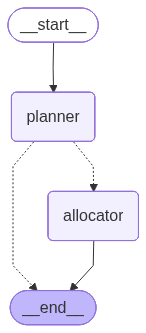

In [5]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
# 그래프 그리기
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# if __name__ == "__main__":
#     print("\n🤖 Agent 1: 서울 여행 플래너입니다! (종료하려면 'q' 입력)")
    
#     # 스레드 ID (사용자 구분용)
#     config = {"configurable": {"thread_id": "test_user_2"}}
    
#     while True:
#         user_input = input("\n👤 유저: ")
#         if user_input.lower() == 'q': break
        
#         # 1. 유저 입력 전달
#         inputs = {
#             "messages": [HumanMessage(content=user_input)]
#         }
        
#         # 2. 그래프 실행
#         # (MemorySaver가 있으니 preferences를 매번 넣을 필요 없음)
#         result_state = app.invoke(inputs, config=config)
        
#         # 3. 결과 확인
#         current_prefs = result_state['preferences']
#         print(f"📦 최종 데이터: {json.dumps(current_prefs.model_dump(), indent=2, ensure_ascii=False)}")
#         try:
#             current_strategy = result_state['strategy']
#             print(f"📦 최종 전략: {json.dumps(current_strategy.model_dump(), indent=2, ensure_ascii=False)}")
#         except:
#             pass

#         if not current_prefs.is_complete:
#             # AI의 질문 출력
#             print()
#             print(f"🤖 Agent: {current_prefs.missing_info_question}")
            
#             # (디버깅용: 현재 채워진 상태 보기)
#             # print(f"   (Debug: {current_prefs.model_dump(exclude={'missing_info_question', 'is_complete', 'additional_notes'}, mode='json')})")


🤖 Agent 1: 서울 여행 플래너입니다! (종료하려면 'q' 입력)
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
📦 최종 데이터: {
  "duration": 1,
  "target_area": "연남동",
  "themes": [
    "맛집",
    "쇼핑"
  ],
  "intensity": 50,
  "companions": "친구",
  "transport": null,
  "is_complete": false,
  "missing_info_question": "이동 수단은 어떻게 하실 계획이신가요?",
  "additional_notes": "점심과 저녁 사이에 쇼핑을 무조건 2군데 이상 걸어서 다니실 예정입니다. 낮에는 맛집 위주로 식사하시고, 중간중간 카페도 방문하고 싶어 하십니다."
}

🤖 Agent: 이동 수단은 어떻게 하실 계획이신가요?
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---
📦 최종 데이터: {
  "duration": 2,
  "target_area": "연남동",
  "themes": [
    "맛집",
    "쇼핑"
  ],
  "intensity": 50,
  "companions": "친구",
  "transport": null,
  "is_complete": false,
  "missing_info_question": "이동 수단은 어떻게 하실 계획이신가요?",
  "additional_notes": "점심과 저녁 사이에 쇼핑을 무조건 2군데 이상 걸어서 다니실 예정입니다. 낮에는 맛집 위주로 식사하시고, 중간중간 카페도 방문하고 싶어 하십니다."
}

🤖 Agent: 이동 수단은 어떻게 하실 계획이신가요?
🤖 --- [Planner Node] 사용자 의도 분석 중. . . ---

⚖️ --- [Agent 2] Kakao 코드 기반 할당 전략 수립 중 ---
allocations=[CategoryAllocation(category_group_cod